<a href="https://colab.research.google.com/github/freyaldi/learn-machine-learning-development/blob/main/time-series/delhi_weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install kaggle and upload kaggle json to download dataset
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ferzareyaldi","key":"e51e2f00de3943063b2c338476100b4a"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d sumanthvrao/daily-climate-time-series-data
! unzip daily-climate-time-series-data.zip

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 21.8MB/s]
Archive:  daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [4]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_temp = min_max_scaler.fit_transform(data_train[['meantemp']])
data_train['meantemp'] = scaled_temp
data_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,0.122271,84.500000,0.000000,1015.666667
1,2013-01-02,0.042795,92.000000,2.980000,1017.800000
2,2013-01-03,0.035662,87.000000,4.633333,1018.666667
3,2013-01-04,0.081514,71.333333,1.233333,1017.166667
4,2013-01-05,0.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,0.342890,68.043478,3.547826,1015.565217
1458,2016-12-29,0.282387,87.857143,6.000000,1016.904762
1459,2016-12-30,0.247453,89.666667,6.266667,1017.904762
1460,2016-12-31,0.276718,87.000000,7.325000,1016.100000


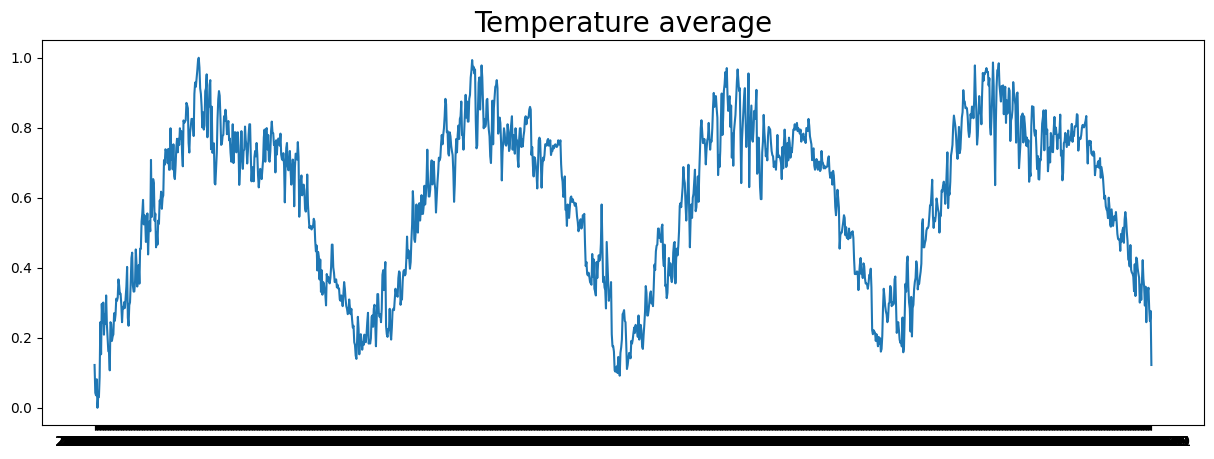

In [5]:
dates = data_train['date'].values
temp  = data_train['meantemp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
train_set = windowed_dataset(temp, window_size=60, batch_size=40, shuffle_buffer=800)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [12]:
threshold_mae = (temp.max() - temp.min()) * 75/1000
threshold_mae

0.075

In [13]:
def scheduler(epoch, lr):
  if epoch % 10 != 0 or epoch == 0:
    return lr
  return lr * 0.1

scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae):
      self.model.stop_training = True

callbacks = myCallback()

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-02, momentum=0.6)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=1000,callbacks=[callbacks, scheduler])

Epoch 1/1000
36/36 [==============================] - 10s 100ms/step - loss: 0.0614 - mae: 0.2822 - lr: 0.0100
Epoch 2/1000
36/36 [==============================] - 3s 80ms/step - loss: 0.0159 - mae: 0.1502 - lr: 0.0100
Epoch 3/1000
36/36 [==============================] - 3s 80ms/step - loss: 0.0142 - mae: 0.1420 - lr: 0.0100
Epoch 4/1000
36/36 [==============================] - 5s 129ms/step - loss: 0.0127 - mae: 0.1334 - lr: 0.0100
Epoch 5/1000
36/36 [==============================] - 3s 79ms/step - loss: 0.0113 - mae: 0.1255 - lr: 0.0100
Epoch 6/1000
36/36 [==============================] - 3s 80ms/step - loss: 0.0099 - mae: 0.1172 - lr: 0.0100
Epoch 7/1000
36/36 [==============================] - 4s 113ms/step - loss: 0.0086 - mae: 0.1086 - lr: 0.0100
Epoch 8/1000
36/36 [==============================] - 3s 79ms/step - loss: 0.0074 - mae: 0.0996 - lr: 0.0100
Epoch 9/1000
36/36 [==============================] - 3s 77ms/step - loss: 0.0063 - mae: 0.0916 - lr: 0.0100
Epoch 10/1000
3

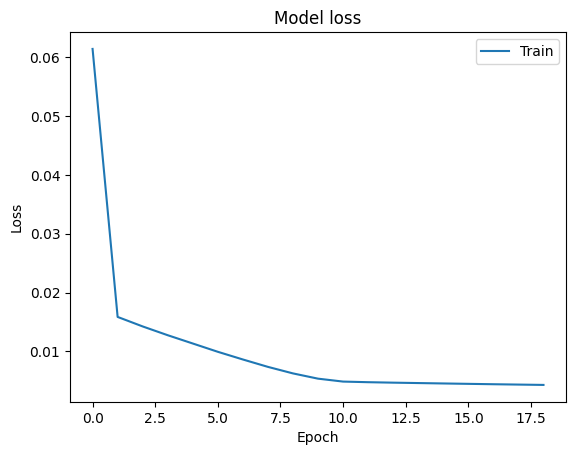

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

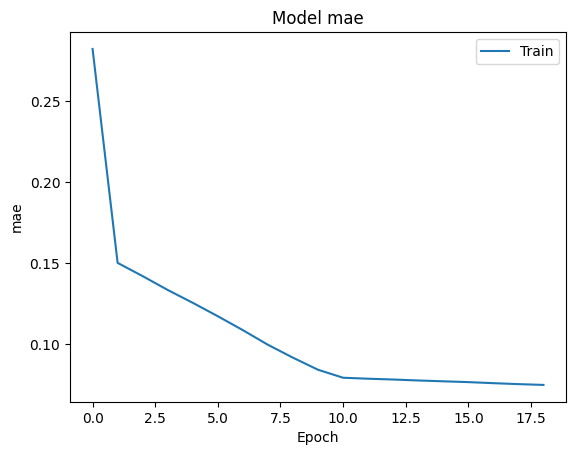

In [16]:
plt.plot(history.history['mae'])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()